# Pricing a European Up-and-out Call Option

<h3><center>Abstract</center></h3>

This report presents the results of the simulation of a European up-and-out call option over twelve months. The Black-Scholes-Merton model will be used to implement Monte Carlo esti- mations using Python code. The estimations will simulate paths for the underlying share and the counterparty’s firm value using varying sample sizes, and determine estimates of both the default-free value of the option and the Credit Valuation Adjustment (CVA). Following from these it is simple to price the option incorporating counterparty risk, given by the default-free price less the CVA.

<br>

#### Keywords: 
Exotic Options, European up-and-out call option, Black-Scholes-Merton model and Geometric Brownian Motion.

## Introduction

A European up-and-out call option is type of a Barrier Option, these options are consider path- dependant because barrier option’s payoff is based on the underlying stock’s price path. The payoff of an up-and-out option at maturity T is given by,
<br>
<br>
<center>$Payoff_T = (S_T - K)^T$  given  $\max_{t\in[0,T]}$  $S_t < L$</center>

Where, where K is the strike of the option, L is the barrier level, and St is the share price at time t.
This is a type of call option whose payoff is reduced to 0 if the share price crosses the barrier level.
<br>
<br>
The seminal work of Merton [1] pioneered the formula for pricing barrier options. This led pricing formulas under the geometric Brownian motion (GBM) framework for one-asset barrier options by Rich [2] and multi-asset barrier options by Wong and Kwok [3]. Although the return dynamics of underlying shares are not sufficiently well described by the GBM process proposed by Black and Scholes [4], we are going to assume both the stock and counterparty firm values follow GBM with constant drift and volatilities and default only occurs at maturity.
Possible paths for the up-and-out barrier option payoff would look similar to the chart below, where two of the paths have crossed the barrier and resulted in zero payoff, but the other three have not crossed the barrier and behave like a vanilla option.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
%matplotlib inline

We initialize most variables as given by the question. We assume the counterparty firm's value is at 200, as this is above the counterparty's debt due in one year. Also, we calculate the default-free value of our option to be 6.60, so we select a firm value not too distant such that the CVA value we calculate is not negligible. For example, if we chose counterparty firm value as 1,000, the CVA would be 0.000.

In [2]:
### Initialize problem parameters
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money
risk_free = .08 # risk-free rate
sigma = .3 # volatility
v_0 = 200 # counterparty firm current value (Our assumption) 
sigma_firm = .25 # volatility for the counterparty's firm
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########
corr_matrix = np.array([[1, corr], [corr, 1]])
sample_sizes = range(1000, 50001, 1000)

## Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option.

Assuming that market has reached current level based on fair trading, and all participants have they same information about underlying asset. We can consider the price of asset to be a stochastic process based on brownian motion with some drift $\mu$ and $\sigma$ diffusion:

\begin{align}
dS_t=S_t(\mu dt + \sigma dW_t)
\end{align}

solving SDE equations and replacing $\mu$ with riskless rate, we can evaluate the share price path as 
\begin{align}
S_t=S_0 e^{(r-\frac{1}{2} \sigma^2)t + \sigma W_t} \\
\end{align}

We use a Cholesky decomposition to generate the correlated price paths

In [3]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
    return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT + sigma*np.sqrt(dT)*Z,1))


def generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 10, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    share_price_path = pd.DataFrame(share_path(S0, risk_free, sigma, Z=corr_norm_matrix[:,0,], dT=1/timesteps))
    share_price_path = share_price_path.transpose()

    firm_price_path = pd.DataFrame(share_path(v_0, risk_free, sigma_firm, Z=corr_norm_matrix[:,1,], dT=1/timesteps))
    firm_price_path = firm_price_path.transpose()

    return [share_price_path,firm_price_path]  

To double check that the stock prices and firm values monthly returns are correlated, we check them as follows, generating 20 different price paths with 10,000 timesteps.

In [4]:
#Testing share and firm price correlation
sample_size = 20
test = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size, timesteps = 10000)

share_ret = np.log(test[0])

for i in range(sample_size):
    test[0]['sharelog'] = np.log(test[0][i])
    test[1]['firmlog'] = np.log(test[1][i])
    pearson, p_value = stats.pearsonr(test[0]['sharelog'].diff().dropna(), test[1]['firmlog'].diff().dropna())
    print("Pearson correlation coefficient : {:.3f}, Two-tailed p-value {:.3f}".format(pearson, p_value))

Pearson correlation coefficient : 0.191, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.198, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.230, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.208, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.207, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.208, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.202, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.205, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.206, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.204, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.195, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.202, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.186, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.166, Two-tailed p-value 0.000
Pearson correlation coefficient : 0.181, Two-tailed p-value 0.000
Pearson co

Let's try to simulate the share price with a small number of sample paths and visualize them over the course of 12 months

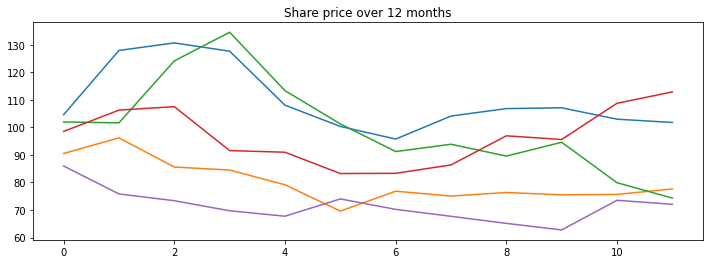

In [5]:
share_and_firm_price_12_months = \
   generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 12)
share_price_12_months = share_and_firm_price_12_months[0]
share_price_12_months.plot(title='Share price over 12 months', legend=False, figsize=(12,4));

We can do the same thing to simulate counterparty firm's value

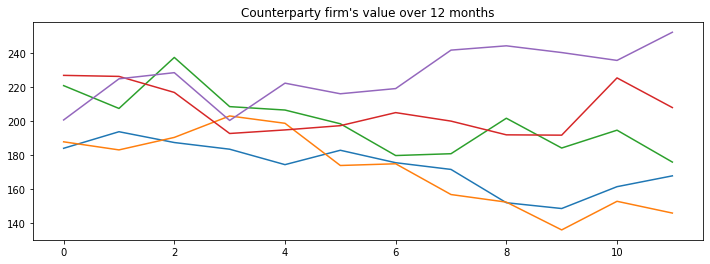

In [6]:
firm_value_12_months = share_and_firm_price_12_months[1]
firm_value_12_months.plot(title="Counterparty firm's value over 12 months", legend=False, figsize=(12,4));

In fact, we can also simulate the dynamic with finer resolution.

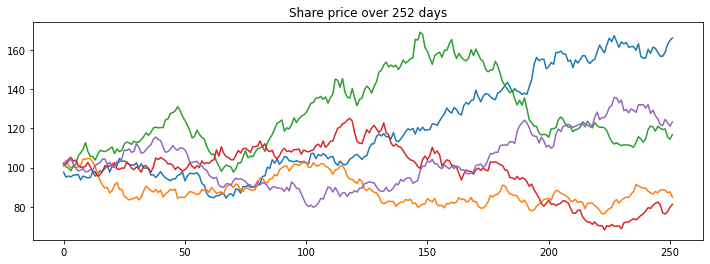

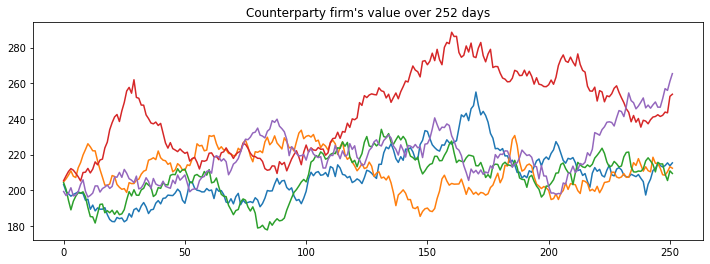

In [7]:
share_and_firm_price_252_days = generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, sample_size = 5, timesteps = 252)
share_price_252_days = share_and_firm_price_252_days[0]
firm_price_252_days = share_and_firm_price_252_days[1]
share_price_252_days.plot(title='Share price over 252 days', legend=False, figsize=(12,4))
firm_price_252_days.plot(title="Counterparty firm's value over 252 days", legend=False, figsize=(12,4));

Let's visualize when the stopped process is appied

In [8]:
def stop(s, cond):
    ret = s.copy()
    r = ret[cond]
    if len(r) > 0:
        ret[r.idxmin():] = 0
    return ret

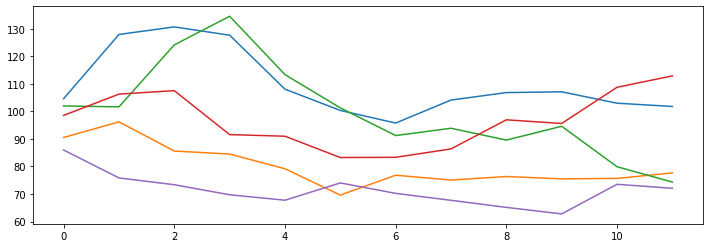

In [9]:
share_price_12_months.apply(lambda s: stop(s, s>L), axis=0)\
                     .plot(legend=False, figsize=(12,4))

We then define a function to calculate the payoff for the up-and-out call option.

In [10]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

payoff(share_price_12_months, K, L)

array([ 1.81747919,  0.        ,  0.        , 12.92678754,  0.        ])

We now create the share and firm price paths for sample sizes 1000, 2000, ...., 50000, as required for part 1 of the assignment.

In [11]:
share_price_paths = {}
firm_val_paths = {}

sample_sizes = range(1000, 50_001, 1000)

for sample_size in sample_sizes:
    share_val, firm_val = \
        generate_share_and_firm_price(S0, v_0, risk_free, sigma, sigma_firm, corr, T, 
                                      sample_size = sample_size, timesteps = 12)
     
    share_price_paths[sample_size] = share_val
    firm_val_paths[sample_size] = firm_val

We now plot the share and firm price paths for sample size of 1000.

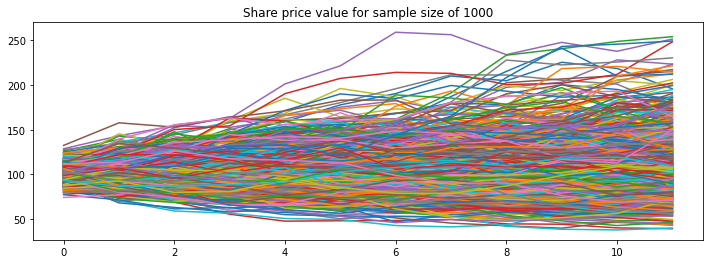

In [12]:
share_price_paths[1000].plot(title="Share price value for sample size of 1000", legend=False, figsize=(12,4));

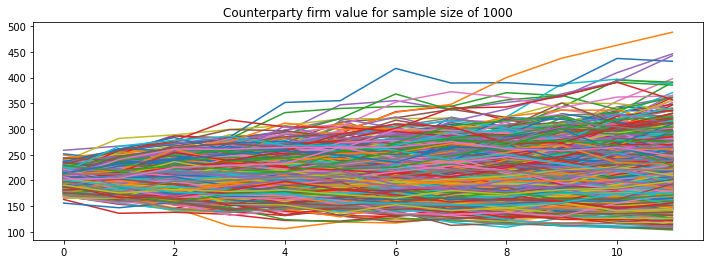

In [13]:
firm_val_paths[1000].plot(title="Counterparty firm value for sample size of 1000", legend=False, figsize=(12,4));

#  Determine the Monte Carlo estimates of the both the default-free value of the option and the Credit Valuation Adjustment

To calculate Monte Carlo estimate of the default-free option value, we calculate the average payoff of the 1000s of sample price paths, to estimate the price of the option

In [14]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs
    option_estimate.append(option_price.mean())
    option_std.append(option_price.std()/np.sqrt(sample_size))


Prices of default-free option at various sample sizes:

In [15]:
for i in range(len(option_estimate)):
    print("sample size: {}, Option value: {:.3f}".format((i+1)*1000,option_estimate[i]))

sample size: 1000, Option value: 6.661
sample size: 2000, Option value: 6.264
sample size: 3000, Option value: 6.870
sample size: 4000, Option value: 6.759
sample size: 5000, Option value: 6.744
sample size: 6000, Option value: 6.790
sample size: 7000, Option value: 6.474
sample size: 8000, Option value: 6.719
sample size: 9000, Option value: 6.756
sample size: 10000, Option value: 6.787
sample size: 11000, Option value: 6.654
sample size: 12000, Option value: 6.500
sample size: 13000, Option value: 6.813
sample size: 14000, Option value: 6.649
sample size: 15000, Option value: 6.689
sample size: 16000, Option value: 6.610
sample size: 17000, Option value: 6.724
sample size: 18000, Option value: 6.637
sample size: 19000, Option value: 6.768
sample size: 20000, Option value: 6.573
sample size: 21000, Option value: 6.612
sample size: 22000, Option value: 6.670
sample size: 23000, Option value: 6.806
sample size: 24000, Option value: 6.666
sample size: 25000, Option value: 6.671
sample si

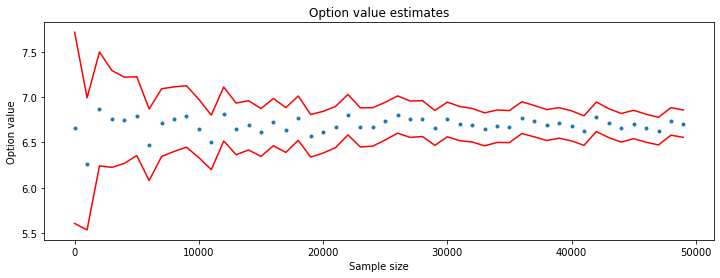

In [16]:
# Confidence level as 99.7 gives 3 std. deviations
confidence_sigma = 3

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(option_estimate, '.')
ax.plot(option_estimate + confidence_sigma * np.array(option_std), 'r')
ax.plot(option_estimate - confidence_sigma * np.array(option_std), 'r')
plt.title("Option value estimates")
plt.xlabel("Sample size")
plt.ylabel("Option value")

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 1000))
ax.xaxis.set_major_formatter(ticks_x)
plt.show()

## CVA Adjustment

To calculate Monte Carlo estimate of the credit value adjustment, we calculate the average loss of the 1000s of sample price paths, which happens when we both see a gain in the option with hold and when the counterparty firm value is less than its debt.


According to Merton model, we can make the same assumptions as the Black-Scholes model, except for the no risk of default assumption: 

\begin{align}
dV_t=V_t(r dt + \sigma dW_t); V_0 = V
\end{align}

I.e. the firm value, can be modeled in the same way as any asset.


As per notes, we assume that default can only occur at time T, and firm defaults if the firm value is below firm debt amount

In [17]:
def terminal_value(S_0, risk_free_rate, sigma, Z, T): #applies to both firm and stock
    return S_0 * np.exp((risk_free_rate - sigma**2/2) * T + sigma * np.sqrt(T) * Z)

In [18]:
cva_estimate = []
cva_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    cva_estimate.append(amount_lost.mean())
    cva_std.append(amount_lost.std()/np.sqrt(sample_size))
    

Credit value adjustment at various sample sizes:

In [19]:
for i in range(len(cva_estimate)):
    print("Sample size: {}, CVA: {:.3f}".format((i+1)*1000,cva_estimate[i]))

Sample size: 1000, CVA: 1.123
Sample size: 2000, CVA: 0.883
Sample size: 3000, CVA: 0.972
Sample size: 4000, CVA: 1.036
Sample size: 5000, CVA: 0.963
Sample size: 6000, CVA: 0.930
Sample size: 7000, CVA: 0.911
Sample size: 8000, CVA: 1.007
Sample size: 9000, CVA: 0.943
Sample size: 10000, CVA: 0.915
Sample size: 11000, CVA: 0.916
Sample size: 12000, CVA: 0.912
Sample size: 13000, CVA: 0.933
Sample size: 14000, CVA: 0.981
Sample size: 15000, CVA: 0.914
Sample size: 16000, CVA: 0.957
Sample size: 17000, CVA: 0.978
Sample size: 18000, CVA: 0.936
Sample size: 19000, CVA: 0.932
Sample size: 20000, CVA: 0.977
Sample size: 21000, CVA: 0.974
Sample size: 22000, CVA: 0.971
Sample size: 23000, CVA: 0.947
Sample size: 24000, CVA: 0.946
Sample size: 25000, CVA: 0.952
Sample size: 26000, CVA: 0.939
Sample size: 27000, CVA: 0.953
Sample size: 28000, CVA: 0.928
Sample size: 29000, CVA: 0.940
Sample size: 30000, CVA: 0.907
Sample size: 31000, CVA: 0.968
Sample size: 32000, CVA: 0.933
Sample size: 3300

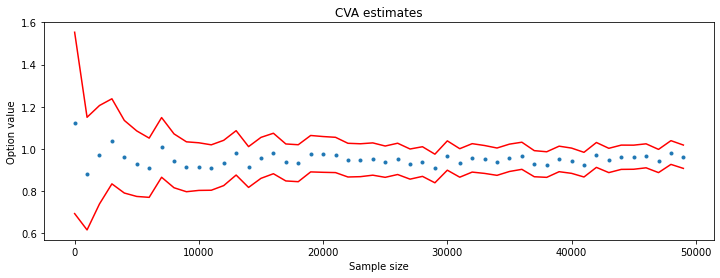

In [20]:
# Confidence level as 99.7 gives 3 std. deviations
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(cva_estimate, '.')
ax.plot(cva_estimate + 3 * np.array(cva_std), 'r')
ax.plot(cva_estimate - 3 * np.array(cva_std), 'r')
plt.title("CVA estimates")
plt.xlabel("Sample size")
plt.ylabel("Option value")

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 1000))
ax.xaxis.set_major_formatter(ticks_x)
plt.show()

# Calculate the Monte Carlo estimates for the price of the option incorporating counterparty risk, given by the default-free price less the CVA.

In [21]:
option_cva_adjusted_prices = []
option_cva_adjusted_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs

    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    
    option_cva_price = option_price - amount_lost
    
    option_cva_adjusted_prices.append(option_cva_price.mean())
    option_cva_adjusted_std.append(option_cva_price.std()/np.sqrt(sample_size))



Credit value adjusted option values at various sample sizes:

In [22]:
for i in range(len(option_cva_adjusted_prices)):
    print("Sample size: {}, CVA-adjusted option value: {:.3f}"
             .format((i+1)*1000, option_cva_adjusted_prices[i]))

Sample size: 1000, CVA-adjusted option value: 5.538
Sample size: 2000, CVA-adjusted option value: 5.381
Sample size: 3000, CVA-adjusted option value: 5.897
Sample size: 4000, CVA-adjusted option value: 5.723
Sample size: 5000, CVA-adjusted option value: 5.782
Sample size: 6000, CVA-adjusted option value: 5.860
Sample size: 7000, CVA-adjusted option value: 5.564
Sample size: 8000, CVA-adjusted option value: 5.712
Sample size: 9000, CVA-adjusted option value: 5.813
Sample size: 10000, CVA-adjusted option value: 5.872
Sample size: 11000, CVA-adjusted option value: 5.738
Sample size: 12000, CVA-adjusted option value: 5.589
Sample size: 13000, CVA-adjusted option value: 5.880
Sample size: 14000, CVA-adjusted option value: 5.668
Sample size: 15000, CVA-adjusted option value: 5.775
Sample size: 16000, CVA-adjusted option value: 5.652
Sample size: 17000, CVA-adjusted option value: 5.746
Sample size: 18000, CVA-adjusted option value: 5.701
Sample size: 19000, CVA-adjusted option value: 5.836
Sa

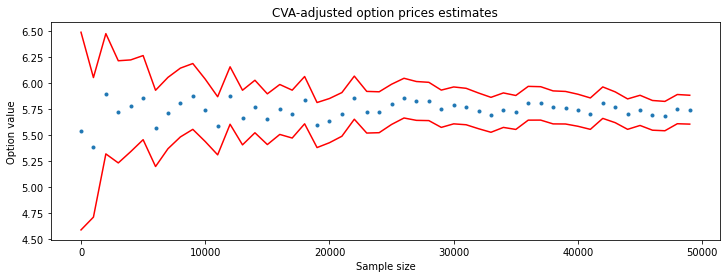

In [23]:
# Confidence level as 99.7 gives 3 std. deviations
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(option_cva_adjusted_prices, '.')
ax.plot(option_cva_adjusted_prices + 3 * np.array(option_cva_adjusted_std), 'r')
ax.plot(option_cva_adjusted_prices - 3 * np.array(option_cva_adjusted_std), 'r')
plt.title("CVA-adjusted option prices estimates")
plt.xlabel("Sample size")
plt.ylabel("Option value")

ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x * 1000))
ax.xaxis.set_major_formatter(ticks_x)
plt.show()

##  Analytic calculations for Black-Scholes-Merton for Barrier Options

Let's calculate the price of European call option (up-and-out) using anlytic formulas 

In [24]:
def call_option(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = (S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    return call

# call up-and-in
def call_ui_option(S, K, T, r, sigma, H):
    if H > K:
        alambda = (r + 0.5 * sigma ** 2) / sigma ** 2
        x1 = np.log(S/H) / (sigma * np.sqrt(T)) + alambda * sigma * np.sqrt(T)
        y1 = np.log(H/S) / (sigma * np.sqrt(T)) + alambda * sigma * np.sqrt(T)
        y = np.log( H ** 2 / (S * K) ) / (sigma * np.sqrt(T)) + alambda * sigma * np.sqrt(T)

        ui1 = S * stats.norm.cdf(x1, 0.0, 1.0)
        ui2 = -K * np.exp(-r * T) * stats.norm.cdf(x1 - sigma * np.sqrt(T))
        ui3 = -S * ((H/S) ** (2 * alambda)) * ( stats.norm.cdf(-y, 0.0, 1.0) - stats.norm.cdf(-y1, 0.0, 1.0))
        ui4 = K * np.exp(-r * T) * ((H / S ) ** (2 * alambda - 2)) * ( 
                              stats.norm.cdf(-y + sigma * np.sqrt(T), 0.0, 1.0) -
                              stats.norm.cdf(-y1 + sigma * np.sqrt(T), 0.0, 1.0)) 
        ui = ui1 + ui2 + ui3 + ui4
    else:
        ui = call_option(S,K,T,r,sigma)

    return ui

def call_uo_option(S, K, T, r, sigma, H):
    if H < K:
        return 0
    else:
        c = call_option(S,K,T,r,sigma)
        ui = call_ui_option(S,K,T,r,sigma,H)
        return c - ui
    
    
CALL_UP_AND_OUT=call_uo_option(S0, K, T, risk_free, sigma, L)
print("Price of call European Option with barrier {:.3f}".format(CALL_UP_AND_OUT))

Price of call European Option with barrier 5.313


# Conclusion

We are well aware that Black-Scholes formula was derived under assumptions which might not hold in a real market, as an example, if the share price deviates from the geometric Brownian motion, then our estimates can be wrong by a big margin. However with the assumptions of Black-Scholes-Merton model we were able to price a European Up-and-out Call Option. 

On the other hand a small amount of samples in Monte-Carlo simulations may result in wrong values. As an example above, the analytical formula gives **5.31**, while Monter-Carlo gives **~6.61**. But increasing the number of samples _(i.e using 365 days and 100,000 - which requires additional hardware resources)_ shows that value converges to analytical value.


In this paper we used Python code for monthly simulations of the lifetime of the option. Also represented the fact that Monte Carlo estimates are highly dependant on parameters such as: sample size, estimated volatility and etc.

The key factor for CVA is the way how firm value and risk of default are estimated. If firm value is well above debt value and the volatility of the firm is low, the chance of default is really low.

# References
1. Merton, Robert C. "Theory of rational option pricing." The Bell Journal of economics and management science (1973): 141-183.
1. Rich, Don R. "The mathematical foundations of barrier option-pricing theory." Ad- vances in futures and options research 7 (1994).
1. Wong, Hoi Ying, and Yue-Kuen Kwok. "Multi-asset barrier options and occupation time derivatives." Applied Mathematical Finance 10.3 (2003): 245-266.
1. Black, Fisher, and Myron Scholes. "The pricing and Corportate Liabilities." Journal of Political Economy 81 (1973).
1. Yousuf, M. "A fourth-order smoothing scheme for pricing barrier options under stochastic volatility." International Journal of Computer Mathematics 86.6 (2009): 1054-1067.